(summary-exercise-stat-interp)=

# Maximum wind speed prediction at the Sprogø station

The exercise goal is to predict the maximum wind speed occurring every
50 years even if no measure exists for such a period. The available
data are only measured over 21 years at the Sprogø meteorological
station located in Denmark. First, the statistical steps will be given
and then illustrated with functions from the `scipy.interpolate` module. At
the end the interested readers are invited to compute results from raw data
and in a slightly different approach.

## Statistical approach

The annual maxima are supposed to fit a normal probability density
function. However such function is not going to be estimated because
it gives a probability from a wind speed maxima. Finding the maximum wind
speed occurring every 50 years requires the opposite approach, the result
needs to be found from a defined probability. That is the quantile function
role and the exercise goal will be to find it. In the current model,
it is supposed that the maximum wind speed occurring every 50 years is
defined as the upper 2% quantile.

By definition, the quantile function is the inverse of the cumulative
distribution function. The latter describes the probability distribution
of an annual maxima. In the exercise, the cumulative probability `p_i`
for a given year `i` is defined as `p_i = i/(N+1)` with `N = 21`,
the number of measured years. Thus it will be possible to calculate
the cumulative probability of every measured wind speed maxima.
From those experimental points, the scipy.interpolate module will be
very useful for fitting the quantile function. Finally the 50 years
maxima is going to be evaluated from the cumulative probability
of the 2% quantile.

## Computing the cumulative probabilities

The annual wind speeds maxima have already been computed and saved in
the NumPy format in the file {download}`examples/max-speeds.npy`, thus they will be loaded
by using NumPy:

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
max_speeds = np.load('examples/max-speeds.npy')
years_nb = max_speeds.shape[0]

Following the cumulative probability definition `p_i` from the previous
section, the corresponding values will be:

In [3]:
cprob = (np.arange(years_nb, dtype=np.float32) + 1) / (years_nb + 1)

and they are assumed to fit the given wind speeds:

In [4]:
sorted_max_speeds = np.sort(max_speeds)

## Prediction with `UnivariateSpline`

In this section the quantile function will be estimated by using the
`UnivariateSpline` class which can represent a spline from points. The
default behavior is to build a spline of degree 3 and points can
have different weights according to their reliability. Variants are
`InterpolatedUnivariateSpline` and `LSQUnivariateSpline` on which
errors checking is going to change. In case a 2D spline is wanted,
the `BivariateSpline` class family is provided. All those classes
for 1D and 2D splines use the FITPACK Fortran subroutines, that's why a
lower library access is available through the `splrep` and `splev`
functions for respectively representing and evaluating a spline.
Moreover interpolation functions without the use of FITPACK parameters
are also provided for simpler use.

For the Sprogø maxima wind speeds, the `UnivariateSpline` will be
used because a spline of degree 3 seems to correctly fit the data:

In [5]:
import scipy as sp

quantile_func = sp.interpolate.UnivariateSpline(cprob, sorted_max_speeds)

The quantile function is now going to be evaluated from the full range
of probabilities:

In [6]:
nprob = np.linspace(0, 1, 100)
fitted_max_speeds = quantile_func(nprob)

In the current model, the maximum wind speed occurring every 50 years is
defined as the upper 2% quantile. As a result, the cumulative probability
value will be:

In [7]:
fifty_prob = 1. - 0.02

So the storm wind speed occurring every 50 years can be guessed by:

In [8]:
fifty_wind = quantile_func(fifty_prob)
fifty_wind

array(32.97989825)

The results are now gathered on a Matplotlib figure:

Text(0, 0.5, 'Cumulative probability')

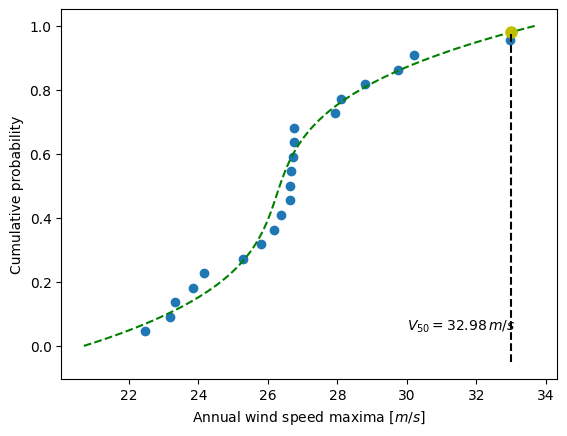

In [9]:
plt.plot(sorted_max_speeds, cprob, "o")
plt.plot(fitted_max_speeds, nprob, "g--")
plt.plot([fifty_wind], [fifty_prob], "o", ms=8.0, mfc="y", mec="y")
plt.text(30, 0.05, rf"$V_{{50}} = {fifty_wind:.2f} \, m/s$")
plt.plot([fifty_wind, fifty_wind], [plt.axis()[2], fifty_prob], "k--")
plt.xlabel("Annual wind speed maxima [$m/s$]")
plt.ylabel("Cumulative probability")

## Exercise with the Gumbell distribution

The interested readers are now invited to make an exercise by using the wind
speeds measured over 21 years. The measurement period is around 90 minutes
(the original period was around 10 minutes but the file size has been reduced
for making the exercise setup easier). The data are stored in NumPy format
inside the file {download}`examples/sprog-windspeeds.npy`. Do not look at the
source code for the plots until you have completed the exercise.

::: {exercise-start}
:label: gumbel-max-ex
:class: dropdown
:::

The **first step** will be to find the annual maxima by using NumPy and plot
them as a matplotlib bar figure.

::: {exercise-end}
:::

::: {solution-start} gumbel-max-ex
:class: dropdown
:::

In [10]:
years_nb = 21
wspeeds = np.load("examples/sprog-windspeeds.npy")
max_speeds = np.array([arr.max() for arr in np.array_split(wspeeds, years_nb)])

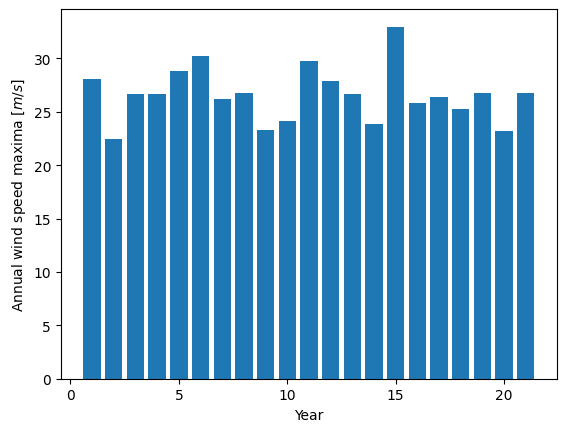

In [11]:
plt.bar(np.arange(years_nb) + 1, max_speeds)
plt.axis("tight")
plt.xlabel("Year")
plt.ylabel("Annual wind speed maxima [$m/s$]");

::: {solution-end}
:::

::: {exercise-start}
:label: gumbel-predict-ex
:class: dropdown
:::

The **second step** will be to use the Gumbell distribution on cumulative
probabilities `p_i` defined as `-log( -log(p_i) )` for fitting a linear
quantile function (remember that you can define the degree of the
`UnivariateSpline`). Plotting the annual maxima versus the Gumbell
distribution should give you the following figure.

The **last step** will be to find 34.23 m/s for the maximum wind speed
occurring every 50 years.

::: {exercise-end}
:::

::: {solution-start} gumbel-predict-ex
:class: dropdown
:::

This follows on from the exercise above.

In [12]:
def gumbell_dist(arr):
    return -np.log(-np.log(arr))

In [13]:
sorted_max_speeds = np.sort(max_speeds)
cprob = (np.arange(years_nb, dtype=np.float32) + 1) / (years_nb + 1)
gprob = gumbell_dist(cprob)
speed_spline = sp.interpolate.UnivariateSpline(gprob, sorted_max_speeds, k=1)
nprob = gumbell_dist(np.linspace(1e-3, 1 - 1e-3, 100))
fitted_max_speeds = speed_spline(nprob)

In [14]:
fifty_prob = gumbell_dist(49.0 / 50.0)
fifty_wind = speed_spline(fifty_prob)

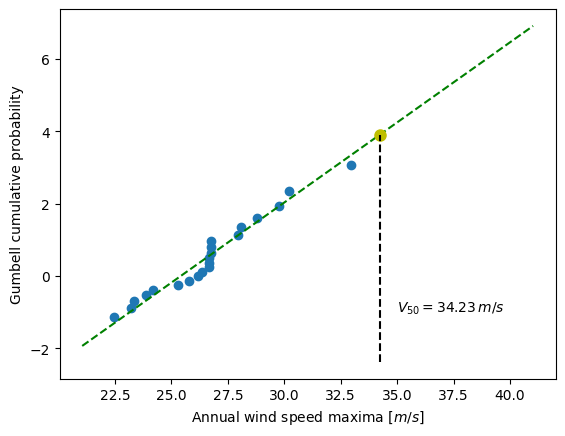

In [15]:
plt.plot(sorted_max_speeds, gprob, "o")
plt.plot(fitted_max_speeds, nprob, "g--")
plt.plot([fifty_wind], [fifty_prob], "o", ms=8.0, mfc="y", mec="y")
plt.plot([fifty_wind, fifty_wind], [plt.axis()[2], fifty_prob], "k--")
plt.text(35, -1, rf"$V_{{50}} = {fifty_wind:.2f} \, m/s$")
plt.xlabel("Annual wind speed maxima [$m/s$]")
plt.ylabel("Gumbell cumulative probability");

::: {solution-end}
:::